In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from comet_ml import Experiment
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import (accuracy_score, dcg_score, roc_auc_score, 
                             precision_score, recall_score)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

from htools import assert_raises, save, load, hdir
from incendio.core import *
from incendio.callbacks import *
from incendio.metrics import *
from incendio.optimizers import *
from incendio.utils import *

In [3]:
# Reproducible testing.
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
class Data(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        self.y = torch.clamp(
            (self.x[:, 0]*.75 + self.x[:, 1]*.25).round(), 0, 1
        ).abs().unsqueeze(-1)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [5]:
class EasyDataset(Dataset):
    
    def __init__(self, n=10, scalar=8):
        """Larger scalar makes data easier to classify."""
        self.x = torch.rand(n).float().unsqueeze(-1)
        self.y = (self.x + torch.randn_like(self.x)/scalar > 0.5).float()
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [6]:
class MulticlassData(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        # Integer labels between 0 and 4, inclusive.
        self.y = torch.clamp(
            torch.round(
                torch.randint(6, (n, 1)).float() 
                * (self.x[:, 0]*.75 + self.x[:, 1]*.25).unsqueeze(-1)
            ), 0, 4).long().flatten()
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [7]:
ypred_ = torch.rand(5, 2)
y_ = torch.tensor([0, 1, 1, 0, 1])
ypred_, y_

(tensor([[0.4963, 0.7682],
         [0.0885, 0.1320],
         [0.3074, 0.6341],
         [0.4901, 0.8964],
         [0.4556, 0.6323]]), tensor([0, 1, 1, 0, 1]))

In [8]:
class SimpleModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 2)
        self.fc2 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [9]:
class GroupedModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        g1 = nn.Sequential(
            nn.Linear(dim, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU()
        )
        g2 = nn.Linear(4, 1)
        self.groups = nn.ModuleList([g1, g2])
        
    def forward(self, x):
        for group in self.groups:
            x = group(x)
        return x

In [10]:
DIM = 2

In [11]:
snet = SimpleModel(DIM)
snet

SimpleModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)

In [12]:
optim = variable_lr_optimizer(snet, 2e-3)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.002
    weight_decay: 0
)

In [13]:
with assert_raises(ValueError) as ar:
    optim = variable_lr_optimizer(snet, [3e-3, 1e-1])
    optim

As expected, got ValueError(Received more learning rates than layer groups.).


In [14]:
update_optimizer(optim, 1e-3, 0.5)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [15]:
snet.freeze()
for n in range(5):
    snet.unfreeze(n_layers=n)
    print(n, snet.trainable())

0 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), False)]
1 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), True)]
2 [((2, 2), False), ((2,), False), ((1, 2), True), ((1,), True)]
3 [((2, 2), False), ((2,), True), ((1, 2), True), ((1,), True)]
4 [((2, 2), True), ((2,), True), ((1, 2), True), ((1,), True)]


In [16]:
snet.freeze()
with assert_raises(AttributeError) as ar:
    for n in range(3):
        snet.unfreeze(n_groups=n)
        print(n, snet.trainable())

As expected, got AttributeError('SimpleModel' object has no attribute 'groups').


# Training

In [17]:
from collections.abc import Iterable, Mapping
from functools import partial

from htools import flatten

In [18]:
def is_builtin(x, drop_callables=True):
    def _builtin(x, drop_callables):
        if callable(x) and drop_callables:
            return False
        return x.__class__.__module__ == 'builtins'
    
    builtin = partial(_builtin, drop_callables=drop_callables)
    # Check mapping before iterable because mappings are iterable.
    if isinstance(x, Mapping):
        return builtin(x) and all(builtin(o) for o in flatten(x.items()))
    elif isinstance(x, Iterable):
        return builtin(x) and all(builtin(o) for o in flatten(x))
    return builtin(x)

# TODO:
-maybe add val batch metrics

-maybe add train metrics (batch and/or epoch)

In [19]:
class CometCallback(TorchCallback):
    
    def __init__(self, project_name, order=100):
        # High order so this comes after MetricHandler.
        self.project_name = project_name
        self.order = order
        # Define when training begins so reported time is more meaningful.
        self.exp = None
    
    def on_train_begin(self, trainer, epochs, lrs, lr_mult, **kwargs):
        self.exp = Experiment(project_name=self.project_name)
        params = {k: v for k, v in vars(trainer).items() if is_builtin(v)}
        self.exp.log_parameters(
            dict(**params, **kwargs, epochs=epochs, lrs=lrs, lr_mult=lr_mult)
        )

    def on_train_end(self, trainer, epoch, val_stats):
        self.exp.end()

    def on_epoch_end(self, trainer, epoch, val_stats):
        self.exp.log_metrics(trainer.stats, prefix='train', epoch=epoch)
        self.exp.log_metrics(val_stats, prefix='val', epoch=epoch)

In [20]:
DIM = 2
metrics = [accuracy_score, 
           precision_score, 
           recall_score, 
           percent_positive,
           mean_soft_prediction
          ]

# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [EarlyStopper('accuracy', 'max', patience=3),
             PerformanceThreshold('recall', 'max', 0.25, skip_epochs=5),
             MetricHistory(),
             ModelUnfreezer({3:1}, 'groups'),
             ModelCheckpoint(),
             CosineLRScheduler(),
             S3Uploader('gg-datascience', 'hmamin/incendio/v1'),
#              CometCallback('incendio-test')
            ]

In [30]:
train = Data(n=10_000, dim=DIM)
val = Data(n=30, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [42]:
gnet = GroupedModel(DIM)
t = Trainer(gnet, train, val, dl_train, dl_val, F.binary_cross_entropy_with_logits, 
            'binary', '../data/v5', optim_type=torch.optim.RMSprop, 
            last_act=torch.sigmoid, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v5')

Datasets: 10000 train rows, 30 val rows

Optimizer: None

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))

In [43]:
t.callbacks

{'BasicConfig': BasicConfig(order=0),
 'StatsHandler': StatsHandler(order=5),
 'MetricPrinter': MetricPrinter(pbar_metric='loss', order=10, batch_freq=1),
 'CosineLRScheduler': CosineLRScheduler(warm=0.3, cycle_len=5, cycle_decay=0.0, restarts=False, verbose=False, min_lr=0.03, order=10),
 'EarlyStopper': EarlyStopper(order=15, metric='accuracy', min_improvement=0.0, patience=3),
 'PerformanceThreshold': PerformanceThreshold(order=15, metric='recall', threshold=0.25, skip_epochs=5, split='val'),
 'ModelUnfreezer': ModelUnfreezer(order=25, mode='epoch'),
 'ModelCheckpoint': ModelCheckpoint(order=25, metric='loss'),
 'MetricHistory': MetricHistory(fname='history.csv', plot_fname='history.png', order=90),
 'S3Uploader': S3Uploader(bucket='gg-datascience', prefix='hmamin/incendio/v1', order=95)}

In [44]:
# t.save('tmp.pkl')

In [45]:
# !ls ../data/v5

In [46]:
# t.load('tmp.pkl')

In [47]:
# d = load('../data/v1/trainer.pkl')

2020-08-26 21:21:54,114 [INFO]: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.03
    momentum: 0
    weight_decay: 0

Parameter Group 1
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.3
    momentum: 0
    weight_decay: 0
)
2020-08-26 21:21:54,114 [INFO]: Removing files from output directory.




=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1223 |       0.0309 |
| accuracy             |  0.9531 |       1.0000 |
| precision            |  0.9487 |       1.0000 |
| recall               |  0.9534 |       1.0000 |
| percent_positive     |  0.4957 |       0.4333 |
| mean_soft_prediction |  0.4933 |       0.4532 |


Saving model. Loss improved from inf to 0.0309.
Writing data to ../data/v5/best_val_metrics.json.




=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0396 |       0.0307 |
| accuracy             |  0.9823 |       0.9667 |
| precision            |  0.9791 |       1.0000 |
| recall               |  0.9766 |       0.9111 |
| percent_positive     |  0.4921 |       0.4000 |
| mean_soft_prediction |  0.4914 |       0.4134 |


Saving model. Loss improved from 0.0309 to 0.0307.
Writing data to ../data/v5/best_val_metrics.json.

Training complete. Model in eval mode.


  0%|          | 0/6 [00:00<?, ?it/s]

File: ../data/v5/history.csv
Bucket: gg-datascience
Key: hmamin/incendio/v1/history.csv
File: ../data/v5/train.log
Bucket: gg-datascience
Key: hmamin/incendio/v1/train.log
File: ../data/v5/best_val_metrics.json
Bucket: gg-datascience
Key: hmamin/incendio/v1/best_val_metrics.json
File: ../data/v5/trainer.pkl
Bucket: gg-datascience
Key: hmamin/incendio/v1/trainer.pkl
File: ../data/v5/lrs.png
Bucket: gg-datascience
Key: hmamin/incendio/v1/lrs.png


  0%|          | 0/6 [00:00<?, ?it/s]

File: ../data/v5/history.png
Bucket: gg-datascience
Key: hmamin/incendio/v1/history.png


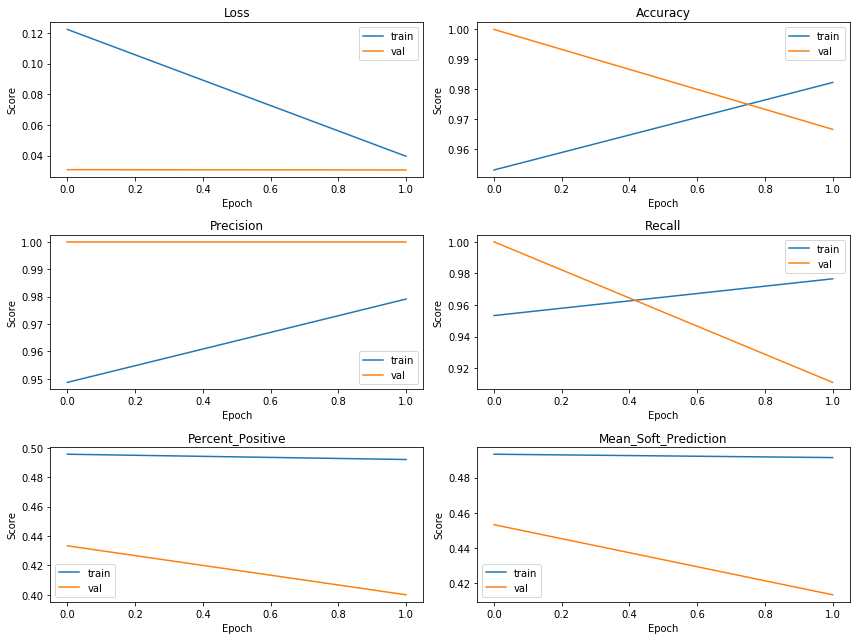

In [48]:
t.fit(2, 3e-1, .1, clean=True)

In [ ]:
!ls ../data/v5

best_val_metrics.json history.png           train.log
history.csv           lrs.png               trainer.pkl


In [ ]:
t.load('trainer.pkl')

In [ ]:
t2 = Trainer.from_file(os.path.join('..', 'data', 'v1', 'trainer.zip'))
print(t2)
del t2; gc.collect()

Object loaded from ../data/v1/trainer.zip.
Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1')

Datasets: 300 train rows, 30 val rows

Optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.015052040053751204
    momentum: 0
    weight_decay: 0

Parameter Group 1
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.030104080107502408
    momentum: 0
    weight_decay: 0
)

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))


19995

In [ ]:
try:
    for i in range(10):
        time.sleep(1)
        print(i)
except KeyboardInterrupt:
    print('Interrupt')

0
1
Interrupt


### Test is_builtin

In [24]:
is_builtin([{'3': t}])

True

In [25]:
is_builtin([2,4])

True

In [43]:
# classes have class `type` so are always considered builtin (if we specify
# drop_callable=False). Can't remember what my original use case was so not
# sure if this is desired.
is_builtin(F.relu, False), is_builtin(nn.ReLU(), False)

(True, False)

In [26]:
print(t.optim_type)
is_builtin(t.optim_type), is_builtin(t.optim_type, False)

<class 'torch.optim.rmsprop.RMSprop'>


(False, True)

In [27]:
is_builtin(torch.sigmoid), is_builtin(torch.sigmoid, False)

(False, True)

In [28]:
is_builtin([1,2,3])

True

In [29]:
is_builtin([TorchCallback, Trainer]), is_builtin([TorchCallback, Trainer], False)

(False, True)

In [30]:
is_builtin({'a': 1, 'c': 33, 'd': [2, 4]})

True

In [31]:
is_builtin({'a': 1, 'c': 33, 't': t.optim_type}), is_builtin({'a': 1, 'c': 33, 't': t.optim_type}, False)

(False, True)

In [32]:
d = {k: v for k, v in vars(t).items() if is_builtin(v)}
d

{'optim': None,
 'eps': 0.001,
 'mode': 'binary',
 'thresh': 0.5,
 '_stop_training': False,
 'out_dir': '../data/v5'}

In [33]:
d2 = dict(c=3333, z=[44, 55], x=True)
{**d, **d2, 'e': 44}

{'optim': None,
 'eps': 0.001,
 'mode': 'binary',
 'thresh': 0.5,
 '_stop_training': False,
 'out_dir': '../data/v5',
 'c': 3333,
 'z': [44, 55],
 'x': True,
 'e': 44}

In [34]:
dict(d, **d2, abc=33, xyz='abc')

{'optim': None,
 'eps': 0.001,
 'mode': 'binary',
 'thresh': 0.5,
 '_stop_training': False,
 'out_dir': '../data/v5',
 'c': 3333,
 'z': [44, 55],
 'x': True,
 'abc': 33,
 'xyz': 'abc'}

## Sawtooth Scheduler

In [ ]:
DIM = 2
metrics = [accuracy_score, 
           precision_score, 
           recall_score]

callbacks = [MetricHistory(),
             AdaptiveSawtoothScheduler(1e-2, .8)]

In [ ]:
train = EasyDataset(400, 100)
val = EasyDataset(40, 100)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
snet = SimpleModel(1)
t = Trainer(snet, train, val, dl_train, dl_val, 
            F.binary_cross_entropy_with_logits, 'multiclass', '../data/v1', 
            metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1')

Datasets: 400 train rows, 40 val rows

Optimizer: None

SimpleModel(
  (fc1): Linear(in_features=1, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
))

2020-03-25 21:17:05,968 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.1
    weight_decay: 0
)
2020-03-25 21:17:05,968 [INFO]: Removing files from output directory.




2020-03-25 21:17:06,163
 
=====

Epoch 0

| Metric    |   Train |   Validation |
|-----------|---------|--------------|
| loss      |  0.3081 |       0.0764 |
| accuracy  |  0.5150 |       0.4500 |
| precision |  0.0000 |       0.0000 |
| recall    |  0.0000 |       0.0000 |

=====




2020-03-25 21:17:06,340
 
=====

Epoch 1

| Metric    |   Train |   Validation |
|-----------|---------|--------------|
| loss      |  0.0940 |       0.0453 |
| accuracy  |  0.5150 |       0.4500 |
| precision |  0.0000 |       0.0000 |
| recall    |  0.0000 |       0.0000 |

=====




2020-03-25 21:17:06,508
 
=====

Epoch 2

| Metric    |   Train |   Validation |
|-----------|---------|--------------|
| loss      |  0.0738 |       0.0420 |
| accuracy  |  0.5150 |       0.4500 |
| precision |  0.0000 |       0.0000 |
| recall    |  0.0000 |       0.0000 |

=====




2020-03-25 21:17:06,658
 
=====

Epoch 3

| Metric    |   Train |   Validation |
|-----------|---------|--------------|
| loss      |  0.0699 |       0.0422 |
| accuracy  |  0.5150 |       0.4500 |
| precision |  0.0000 |       0.0000 |
| recall    |  0.0000 |       0.0000 |

=====




2020-03-25 21:17:06,817
 
=====

Epoch 4

| Metric    |   Train |   Validation |
|-----------|---------|--------------|
| loss      |  0.0695 |       0.0422 |
| accuracy  |  0.5150 |       0.4500 |
| precision |  0.0000 |       0.0000 |
| recall    |  0.0000 |       0.0000 |

=====

2020-03-25 21:17:06,818
 Training complete. Model in eval mode.


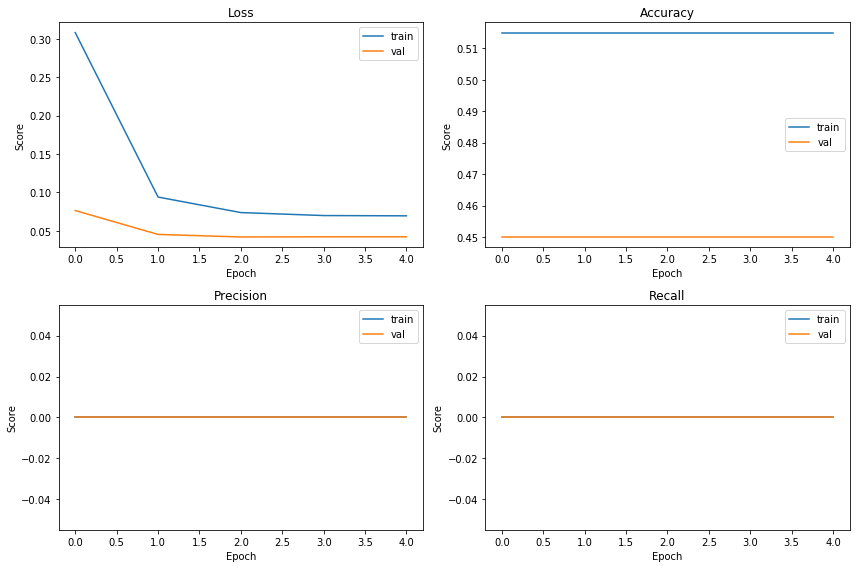

In [ ]:
t.fit(5, 1e-1, clean=True)

In [ ]:
t.callbacks['AdaptiveSawtoothScheduler'].plot_lrs('adaptive_sawtooth_lrs.png')

## Multiclass classification

In [ ]:
class SimpleMulticlassModel(BaseModel):
    
    def __init__(self, dim, classes):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 10)
        self.fc2 = nn.Linear(10, classes)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
DIM = 2
metrics = [accuracy_score,
           mean_soft_prediction
          ]

callbacks = [
#              EarlyStopper('accuracy', 'max', patience=10),
             PerformanceThreshold('loss', 'min', 2, skip_epochs=5),
             MetricHistory(),
             ModelCheckpoint(),
             MetricHistory(),
             CosineLRScheduler(),
             S3Uploader('gg-datascience', 'hmamin/incendio/v2')
            ]

In [ ]:
train = MulticlassData(n=88, dim=DIM)
val = MulticlassData(n=40, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
smnet = SimpleMulticlassModel(DIM, 5)
t = Trainer(smnet, train, val, dl_train, dl_val, 
            F.cross_entropy, 'multiclass', '../data/v1',
            last_act=F.softmax, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='cross_entropy', out_dir='../data/v1')

Datasets: 88 train rows, 40 val rows

Optimizer: None

SimpleMulticlassModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.3
    weight_decay: 0
)




2020-02-19 16:50:12,246
 
=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.5746 |       1.5252 |
| accuracy             |  0.2273 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,247
 Saving model. Loss improved from inf to 1.5252.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,286
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4841 |       1.5531 |
| accuracy             |  0.3636 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,445
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4658 |       1.5053 |
| accuracy             |  0.2841 |       0.2750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,446
 Saving model. Loss improved from 1.5252 to 1.5053.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,486
 
=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4311 |       1.4825 |
| accuracy             |  0.3523 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,487
 Saving model. Loss improved from 1.5053 to 1.4825.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,528
 
=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3938 |       1.4890 |
| accuracy             |  0.3182 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,567
 
=====

Epoch 5

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3632 |       1.4671 |
| accuracy             |  0.3295 |       0.3750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,568
 Saving model. Loss improved from 1.4825 to 1.4671.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,607
 
=====

Epoch 6

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3797 |       1.5319 |
| accuracy             |  0.3750 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,645
 
=====

Epoch 7

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4439 |       1.4302 |
| accuracy             |  0.2500 |       0.3750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,646
 Saving model. Loss improved from 1.4671 to 1.4302.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,683
 
=====

Epoch 8

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4423 |       1.4877 |
| accuracy             |  0.3750 |       0.2750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,720
 
=====

Epoch 9

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4118 |       1.4260 |
| accuracy             |  0.2614 |       0.3750 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,721
 Saving model. Loss improved from 1.4302 to 1.4260.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,762
 
=====

Epoch 10

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3246 |       1.6506 |
| accuracy             |  0.3409 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,800
 
=====

Epoch 11

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4122 |       1.4588 |
| accuracy             |  0.3636 |       0.2250 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,838
 
=====

Epoch 12

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3587 |       1.5368 |
| accuracy             |  0.3750 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,879
 
=====

Epoch 13

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3318 |       1.4431 |
| accuracy             |  0.3523 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:12,918
 
=====

Epoch 14

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3460 |       1.4037 |
| accuracy             |  0.3636 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:12,919
 Saving model. Loss improved from 1.4260 to 1.4037.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:50:12,959
 
=====

Epoch 15

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3139 |       1.4650 |
| accuracy             |  0.3864 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:13,000
 
=====

Epoch 16

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3258 |       1.4417 |
| accuracy             |  0.3864 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:13,039
 
=====

Epoch 17

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2968 |       1.4104 |
| accuracy             |  0.3864 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:13,079
 
=====

Epoch 18

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2847 |       1.4272 |
| accuracy             |  0.3977 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====




2020-02-19 16:50:13,117
 
=====

Epoch 19

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2826 |       1.4363 |
| accuracy             |  0.3864 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |

=====

2020-02-19 16:50:13,118
 Training complete. Model in eval mode.


  0%|          | 0/5 [00:00<?, ?it/s]


2020-02-19 16:50:13,808
 Failed to upload ../data/v1/train.log to gg-datascience/hmamin/incendio/v2/train.log: An error occurred (ExpiredToken) when calling the PutObject operation: The provided token has expired.


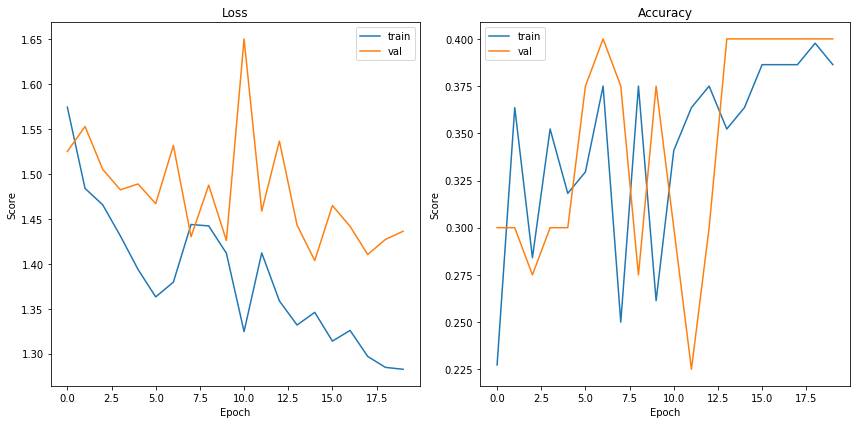

In [ ]:
t.fit(20, .3)

## Easy binary classification

In [ ]:
DIM = 2
metrics = [accuracy_score,
           mean_soft_prediction
          ]

# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [
    MetricHistory(),
    ModelCheckpoint(),
    MetricHistory(),
]

In [ ]:
train = EasyDataset(400, 100)
val = EasyDataset(40, 100)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
snet = SimpleModel(1)
t = Trainer(snet, train, val, dl_train, dl_val, 
            F.binary_cross_entropy_with_logits, 'multiclass', '../data/v1', 
            last_act=torch.sigmoid, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1')

Datasets: 400 train rows, 40 val rows

Optimizer: None

SimpleModel(
  (fc1): Linear(in_features=1, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.1
    weight_decay: 0
)




2020-02-19 16:53:31,492
 
=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.6242 |       0.4281 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4767 |       0.4384 |

=====

2020-02-19 16:53:31,492
 Saving model. Loss improved from inf to 0.4281.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,576
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.2702 |       0.1758 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4262 |       0.5940 |

=====

2020-02-19 16:53:31,577
 Saving model. Loss improved from 0.4281 to 0.1758.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,653
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1424 |       0.1053 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4689 |       0.5977 |

=====

2020-02-19 16:53:31,654
 Saving model. Loss improved from 0.1758 to 0.1053.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,734
 
=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0963 |       0.0617 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4778 |       0.5728 |

=====

2020-02-19 16:53:31,734
 Saving model. Loss improved from 0.1053 to 0.0617.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,812
 
=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0894 |       0.0497 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4825 |       0.5574 |

=====

2020-02-19 16:53:31,812
 Saving model. Loss improved from 0.0617 to 0.0497.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,890
 
=====

Epoch 5

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0752 |       0.0413 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4840 |       0.5723 |

=====

2020-02-19 16:53:31,891
 Saving model. Loss improved from 0.0497 to 0.0413.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:31,970
 
=====

Epoch 6

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0694 |       0.0355 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4844 |       0.5674 |

=====

2020-02-19 16:53:31,972
 Saving model. Loss improved from 0.0413 to 0.0355.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:32,051
 
=====

Epoch 7

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0642 |       0.0316 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4819 |       0.5716 |

=====

2020-02-19 16:53:32,051
 Saving model. Loss improved from 0.0355 to 0.0316.
Data written to ../data/v1/trainer.pkl.




2020-02-19 16:53:32,128
 
=====

Epoch 8

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0623 |       0.0731 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4835 |       0.6086 |

=====




2020-02-19 16:53:32,208
 
=====

Epoch 9

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0514 |       0.0296 |
| accuracy             |  0.5125 |       0.4250 |
| mean_soft_prediction |  0.4870 |       0.5620 |

=====

2020-02-19 16:53:32,209
 Saving model. Loss improved from 0.0316 to 0.0296.
Data written to ../data/v1/trainer.pkl.

2020-02-19 16:53:32,211
 Training complete. Model in eval mode.


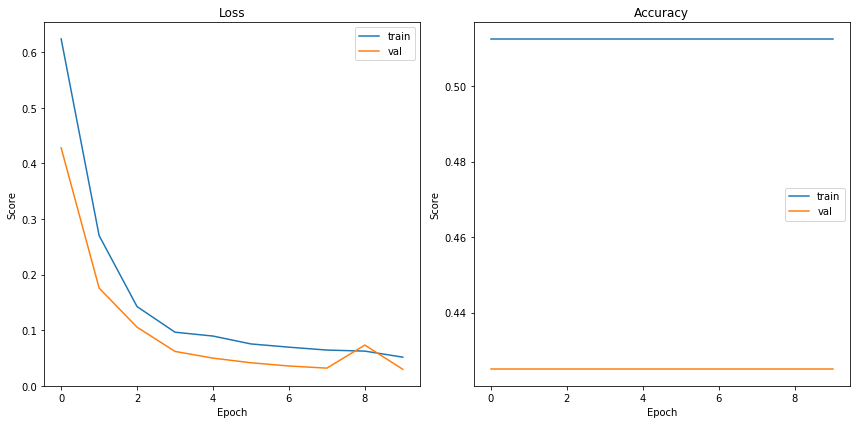

In [ ]:
t.fit(10, .1)

### Scratch

In [ ]:
import inspect

In [ ]:
[getattr(t, k, None) for k in inspect.signature(Trainer).parameters]

[SimpleModel(
   (fc1): Linear(in_features=1, out_features=2, bias=True)
   (fc2): Linear(in_features=2, out_features=1, bias=True)
 ),
 <function torch.nn.functional.binary_cross_entropy_with_logits(input, target, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)>,
 'multiclass',
 '../data/v1',
 torch.optim.adam.Adam,
 0.001,
 <function _VariableFunctions.sigmoid>,
 None,
 [<function incendio.metrics.batch_size(y_true, y_pred)>,
  <function sklearn.metrics._classification.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)>,
  <function incendio.metrics.mean_soft_prediction(y_true, y_score)>],
 {'BasicConfig': BasicConfig(priority=0),
  'StatsHandler': StatsHandler(priority=5),
  'MetricPrinter': MetricPrinter(priority=10),
  'ModelCheckpoint': ModelCheckpoint(priority=25, metric='loss'),
  'MetricHistory': MetricHistory(fname='history.csv', plot_fname='history.png', priority=90)},
 device(type='cpu')]

In [ ]:
from spellotape.dl import inverse_sigmoid

In [ ]:
inverse_sigmoid(.625)

0.5108256237659907

In [ ]:
*x, y = next(iter(dl_train))
x, y

In [ ]:
yhat = smnet(*x)
yhat

In [ ]:
y.shape, yhat.shape

In [ ]:
F.softmax(yhat, dim=-1)

In [ ]:
yhat.shape, y.shape

In [ ]:
F.cross_entropy(yhat, y)

In [ ]:
t = Trainer(smnet, train, val, dl_train, dl_val, F.cross_entropy, 'multiclass',
        '../data/v2', 'datascience-delphi-dev', last_act=partial(F.softmax, dim=-1),
            metrics=metrics, callbacks=callbacks)
t

In [ ]:
import time
from functools import wraps

def catch_keyboard_interrupt(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except KeyboardInterrupt:
            print('interrupt', dir(func))
            # This sets a class variable, not an instance var. Works but not ideal.
            setattr(eval(Foo.bar.__qualname__.split('.')[0]), 'stop', True)
        return
    return wrapper


def catch_method_interrupt(meth_name):
    def decorator(cls):
        func = getattr(cls, meth_name)
        print(func)
        @wraps(func)
        def wrapper(*args, **kwargs):
            print(args, kwargs)
            try:
                func(*args, **kwargs)
            except KeyboardInterrupt:
                print('interrupt', dir(func))
                # This sets a class variable, not an instance var. Works but not ideal.
                setattr(cls, 'stop', True)
            return
        return wrapper
    return decorator


class Foo:
    
    def __init__(self, a):
        self.a = a
        
    @catch_keyboard_interrupt
    def bar(self, b=3):
        for i in range(b):
            time.sleep(1)
            print(self.a)
            

@catch_method_interrupt('train')
class Fizz:

        def __init__(self, a):
            self.a = a
            
        def walk(self, t=5):
            for i in range(t):
                time.sleep(1)
                print(i)
                
        def train(self, epochs):
            for e in epochs:
                print(e)
                time.sleep(1)

<function Fizz.train at 0x14264a0e0>


In [ ]:
f = Foo(5)
f.__dict__

{'a': 5}

In [ ]:
f.bar()

5
interrupt ['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [ ]:
f.__dict__

{'a': 5}

In [ ]:
Foo.stop

True

In [ ]:
f.stop

True

In [ ]:
fizz = Fizz(6)
fizz.walk()

(6,) {}


TypeError: train() missing 1 required positional argument: 'epochs'